Fourth sandbox. In sandbox 3, the plot of F1 against `train_size` seemed to have an elbow at around 0.6, which happened to be the `train_size` used for the original bootstrap. This sandbox tests the following hypothesis:
- if the bootstrapping was done with `train_size=0.1`, then the metrics generated across model predictions using `train_test_split` will have an elbow around `train_size=0.1`
- if the bootstrapping was done with `train_size=0.2`, then the metrics generated across model predictions using `train_test_split` will have an elbow around `train_size=0.2`
- and so on.

In [2]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
# https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
df = pd.read_csv('creditcard.csv')
print(df.columns)
print(df['Class'].value_counts())

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')
Class
0    284315
1       492
Name: count, dtype: int64


In [4]:
all_x = df[df.columns[:-1]]
all_y = df['Class']

In [8]:
def fit_with_size(X_sample, y_sample, seed, train_size, verbose=False):
    X_train, X_test, y_train, y_test = train_test_split(
        X_sample, y_sample,
        train_size=train_size,
        stratify=y_sample,
        random_state=seed  # make less random
    )

    if verbose:
        print("Fitting model with", train_size, "of the data...", end=' ')
        start_time = time()
    np.random.seed(seed)  # make less random
    model = DecisionTreeClassifier().fit(X_train, y_train)
    if verbose:
        end_time = time()
        print("done in", round(end_time-start_time), "seconds.")

    return model, X_test, y_test

In [10]:
def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)

    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return precision, recall, f1

In [15]:
# https://www.kdnuggets.com/2023/03/bootstrapping.html
def bootstrap(X_df, y_df, n_samples, train_size):
    results = []
    for i in tqdm(range(n_samples)):
        run = {}
        np.random.seed(i)  # make less random
        indices = np.random.choice(X_df.shape[0], size=X_df.shape[0], replace=True)
        X_sample = X_df.values[indices, :]
        y_sample = y_df.values[indices]

        model, X_test, y_test = fit_with_size(X_sample, y_sample, i, train_size)
        precision, recall, f1 = get_metrics(model, X_test, y_test)

        run["Seed"] = i
        run["Precision"] = precision
        run["Recall"] = recall
        run["F1"] = f1
        run["Indices"] = indices
        results.append(run)
    return pd.DataFrame(results)

In [69]:
sizes = (0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8)
data = {}
for s_boot in sizes:
    print("Bootstrapping with size", s_boot)
    pred_df = bootstrap(all_x, all_y, 10, s_boot)
    
    best_idx = pred_df.sort_values(by="F1", ascending=False).index[0]
    bootstrapped_idx = pred_df.iloc[best_idx]["Indices"]
    bootstrapped_seed = pred_df.iloc[best_idx]["Seed"]
    
    X_sample = all_x.values[bootstrapped_idx, :]
    y_sample = all_y.values[bootstrapped_idx]

    fit = []
    for s_fit in sizes:
        model, X_test, y_test = fit_with_size(X_sample, y_sample, bootstrapped_seed, s_fit, verbose=True)
        precision, recall, f1 = get_metrics(model, X_test, y_test)
        fit.append(f1)
    data[s_boot] = fit

Bootstrapping with size 0.1


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.10s/it]


Fitting model with 0.1 of the data... done in 1 seconds.
Fitting model with 0.2 of the data... done in 2 seconds.
Fitting model with 0.3 of the data... done in 3 seconds.
Fitting model with 0.4 of the data... done in 4 seconds.
Fitting model with 0.5 of the data... done in 5 seconds.
Fitting model with 0.6 of the data... done in 7 seconds.
Fitting model with 0.7 of the data... done in 9 seconds.
Fitting model with 0.8 of the data... done in 9 seconds.
Bootstrapping with size 0.2


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:23<00:00,  2.34s/it]


Fitting model with 0.1 of the data... done in 1 seconds.
Fitting model with 0.2 of the data... done in 1 seconds.
Fitting model with 0.3 of the data... done in 3 seconds.
Fitting model with 0.4 of the data... done in 4 seconds.
Fitting model with 0.5 of the data... done in 6 seconds.
Fitting model with 0.6 of the data... done in 8 seconds.
Fitting model with 0.7 of the data... done in 8 seconds.
Fitting model with 0.8 of the data... done in 9 seconds.
Bootstrapping with size 0.3


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:40<00:00,  4.02s/it]


Fitting model with 0.1 of the data... done in 1 seconds.
Fitting model with 0.2 of the data... done in 2 seconds.
Fitting model with 0.3 of the data... done in 4 seconds.
Fitting model with 0.4 of the data... done in 5 seconds.
Fitting model with 0.5 of the data... done in 8 seconds.
Fitting model with 0.6 of the data... done in 10 seconds.
Fitting model with 0.7 of the data... done in 10 seconds.
Fitting model with 0.8 of the data... done in 12 seconds.
Bootstrapping with size 0.4


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:52<00:00,  5.29s/it]


Fitting model with 0.1 of the data... done in 1 seconds.
Fitting model with 0.2 of the data... done in 2 seconds.
Fitting model with 0.3 of the data... done in 4 seconds.
Fitting model with 0.4 of the data... done in 6 seconds.
Fitting model with 0.5 of the data... done in 9 seconds.
Fitting model with 0.6 of the data... done in 9 seconds.
Fitting model with 0.7 of the data... done in 11 seconds.
Fitting model with 0.8 of the data... done in 14 seconds.
Bootstrapping with size 0.5


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:12<00:00,  7.25s/it]


Fitting model with 0.1 of the data... done in 1 seconds.
Fitting model with 0.2 of the data... done in 2 seconds.
Fitting model with 0.3 of the data... done in 4 seconds.
Fitting model with 0.4 of the data... done in 5 seconds.
Fitting model with 0.5 of the data... done in 8 seconds.
Fitting model with 0.6 of the data... done in 9 seconds.
Fitting model with 0.7 of the data... done in 10 seconds.
Fitting model with 0.8 of the data... done in 12 seconds.
Bootstrapping with size 0.6


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:24<00:00,  8.49s/it]


Fitting model with 0.1 of the data... done in 1 seconds.
Fitting model with 0.2 of the data... done in 2 seconds.
Fitting model with 0.3 of the data... done in 3 seconds.
Fitting model with 0.4 of the data... done in 4 seconds.
Fitting model with 0.5 of the data... done in 5 seconds.
Fitting model with 0.6 of the data... done in 7 seconds.
Fitting model with 0.7 of the data... done in 9 seconds.
Fitting model with 0.8 of the data... done in 9 seconds.
Bootstrapping with size 0.7


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:37<00:00,  9.78s/it]


Fitting model with 0.1 of the data... done in 1 seconds.
Fitting model with 0.2 of the data... done in 2 seconds.
Fitting model with 0.3 of the data... done in 4 seconds.
Fitting model with 0.4 of the data... done in 6 seconds.
Fitting model with 0.5 of the data... done in 7 seconds.
Fitting model with 0.6 of the data... done in 9 seconds.
Fitting model with 0.7 of the data... done in 9 seconds.
Fitting model with 0.8 of the data... done in 11 seconds.
Bootstrapping with size 0.8


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:59<00:00, 11.97s/it]


Fitting model with 0.1 of the data... done in 1 seconds.
Fitting model with 0.2 of the data... done in 2 seconds.
Fitting model with 0.3 of the data... done in 4 seconds.
Fitting model with 0.4 of the data... done in 5 seconds.
Fitting model with 0.5 of the data... done in 7 seconds.
Fitting model with 0.6 of the data... done in 9 seconds.
Fitting model with 0.7 of the data... done in 9 seconds.
Fitting model with 0.8 of the data... done in 11 seconds.


In [70]:
df_data = pd.DataFrame(data)
df_data["Size"] = sizes

In [71]:
df_data

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,Size
0,0.740571,0.684492,0.732121,0.683761,0.732121,0.740571,0.615385,0.615385,0.1
1,0.728192,0.789474,0.756005,0.737276,0.756005,0.728192,0.683511,0.683511,0.2
2,0.744868,0.822400,0.835098,0.799387,0.835098,0.744868,0.789555,0.789555,0.3
3,0.807496,0.818671,0.837050,0.850615,0.837050,0.807496,0.822898,0.822898,0.4
4,0.803883,0.845815,0.873118,0.856540,0.873118,0.803883,0.830835,0.830835,0.5
5,0.879607,0.868852,0.840108,0.834225,0.840108,0.879607,0.856354,0.856354,0.6
6,0.875817,0.880866,0.868687,0.898955,0.868687,0.875817,0.906475,0.906475,0.7
7,0.866995,0.902174,0.865979,0.892473,0.865979,0.866995,0.930481,0.930481,0.8


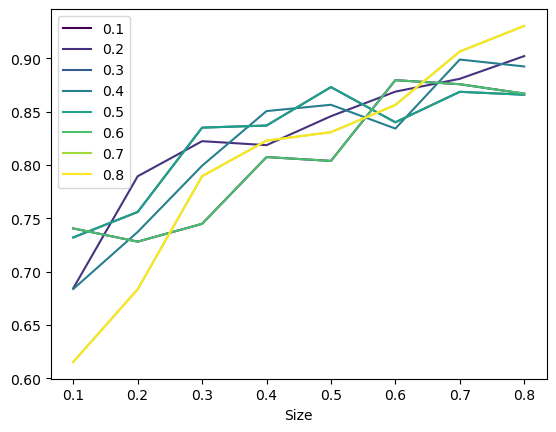

In [115]:
colors = [plt.cm.viridis(s) for s in np.linspace(0, 1, num=len(sizes))]
_ = df_data.plot(x="Size", color=colors)